# Setup - Drive and Repo

In [1]:
import os
import sys
from google.colab import drive

# 1. Mount Drive (Your Data)
drive.mount('/content/drive')

# 2. Sync Code from GitHub
REPO_URL = "https://github.com/brauner68/gm_proj.git"
REPO_NAME = "gm_proj"

if not os.path.exists(f"/content/{REPO_NAME}"):
    print(f"Cloning {REPO_NAME}...")
    !git clone {REPO_URL}
else:
    print(f"Repo exists. Pulling latest changes...")
    %cd /content/{REPO_NAME}
    !git pull

# 3. Enter Project Folder
%cd /content/{REPO_NAME}

# 4. Add to Python Path (Ensures imports work safely)
if f"/content/{REPO_NAME}" not in sys.path:
    sys.path.append(f"/content/{REPO_NAME}")

# 5. Install Dependencies
print("Installing libraries from requirements.txt...")
!pip install -q -r requirements.txt

print("\n✅ SETUP COMPLETE! You are ready to work.")

Mounted at /content/drive
Cloning gm_proj...
Cloning into 'gm_proj'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 290 (delta 30), reused 52 (delta 25), pack-reused 228 (from 1)
Receiving objects: 100% (290/290), 1.59 MiB | 6.90 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/gm_proj
Installing libraries from requirements.txt...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.0 MB/s eta 0:00:00

✅ SETUP COMPLETE! You are ready to work.


# Unzip the data

In [2]:
import torch
# Create a folder for the unzipped data
!mkdir -p /content/nsynth_data

if torch.cuda.is_available():
    !cp "/content/drive/Shareddrives/gm_proj/nsynth-valid.jsonwav.tar.gz" "/content/nsynth-valid.jsonwav.tar.gz"

# Unzip the file (This might take a minute)
# The -C flag tells it where to put the files
print("⏳ Unzipping data...")
!tar -xzf "/content/drive/Shareddrives/gm_proj/nsynth-valid.jsonwav.tar.gz" -C /content/nsynth_data
print("✅ Done!")

⏳ Unzipping data...
✅ Done!


In [4]:
import torch
from src.dataset import NSynthDataset

# 1. Define the specific instruments you want to test
# We choose 3 distinct families to verify the mapping (0, 1, 2)
test_families = ['guitar', 'mallet', 'string']

print(f"--- 🧪 Testing Dataset with families: {test_families} ---")

# 2. Initialize Dataset
valid_path = '/content/nsynth_data/nsynth-valid'
dataset = NSynthDataset(
    data_path=valid_path,
    max_samples=None,
    selected_families=test_families
)

# 3. Create DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

# 4. Fetch one batch
try:
    images, labels = next(iter(dataloader))

    print(f"\n📦 Batch Shape: {images.shape}")
    print(f"🏷️ Raw Labels: {labels}")

    # 5. Verify the Mapping (Reverse lookup: Int -> Name)
    # We invert the dictionary {name: int} -> {int: name}
    int_to_name = {v: k for k, v in dataset.label_map.items()}

    print("\n🔍 Decoded Batch Labels:")
    for i, label_idx in enumerate(labels):
        idx_val = label_idx.item()
        name = int_to_name.get(idx_val, "Unknown")
        print(f"  Sample {i}: Label {idx_val} -> {name}")

    # 6. Sanity Check
    assert labels.max() < len(test_families), "❌ Error: Found a label index larger than the number of selected families!"
    print("\n✅ Sanity Check Passed: All labels are within the valid range [0, 2].")

except StopIteration:
    print("❌ Error: Dataloader is empty. Check your path or filtering logic.")

--- 🧪 Testing Dataset with families: ['guitar', 'mallet', 'string'] ---
Label Map: {'guitar': 0, 'mallet': 1, 'string': 2}
Dataset initialized. 3558 files selected.

📦 Batch Shape: torch.Size([8, 1, 64, 65])
🏷️ Raw Labels: tensor([2, 2, 2, 2, 1, 1, 0, 2])

🔍 Decoded Batch Labels:
  Sample 0: Label 2 -> string
  Sample 1: Label 2 -> string
  Sample 2: Label 2 -> string
  Sample 3: Label 2 -> string
  Sample 4: Label 1 -> mallet
  Sample 5: Label 1 -> mallet
  Sample 6: Label 0 -> guitar
  Sample 7: Label 2 -> string

✅ Sanity Check Passed: All labels are within the valid range [0, 2].


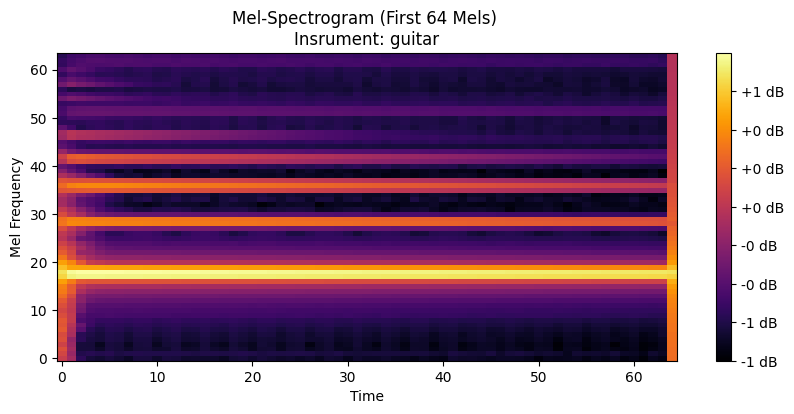

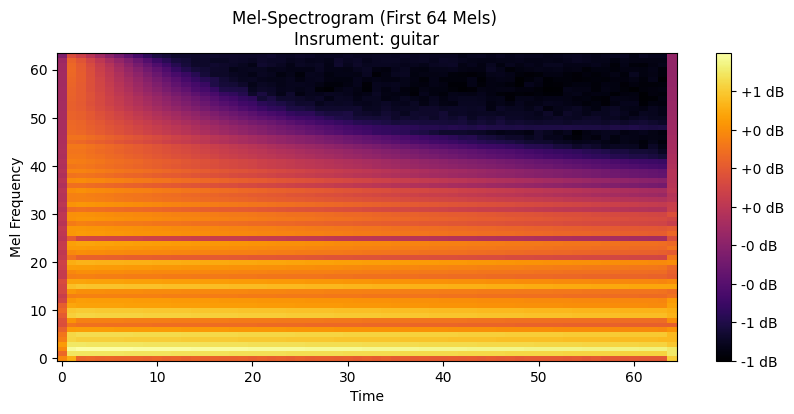

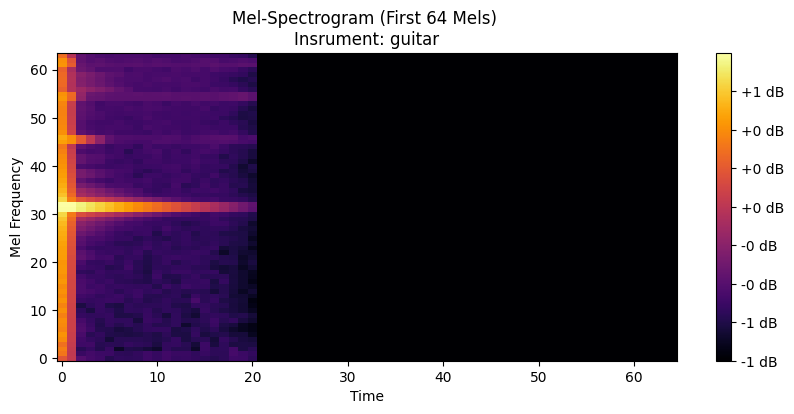

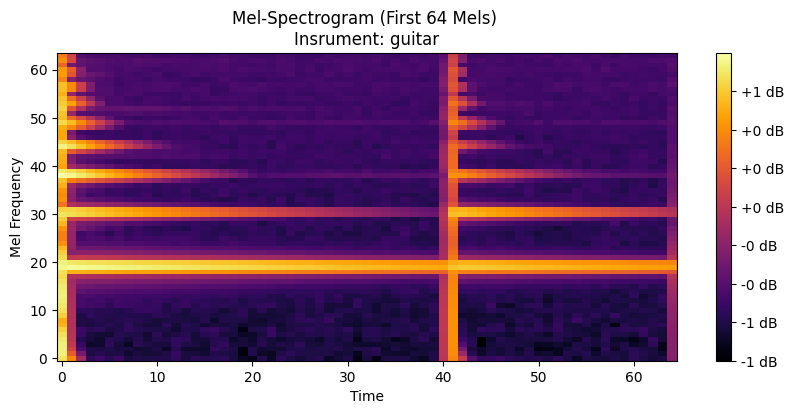

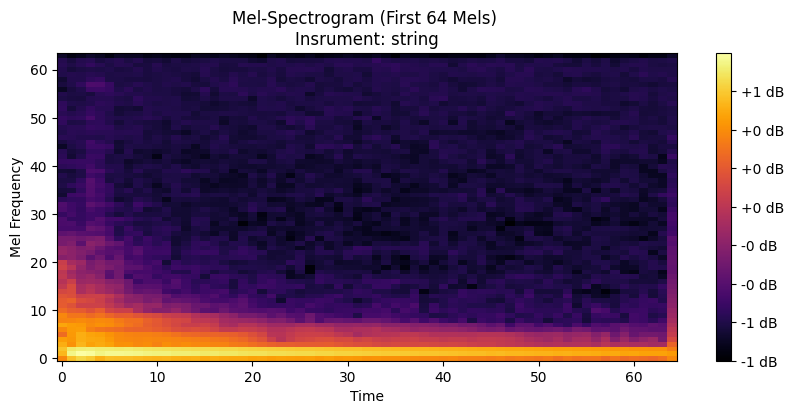

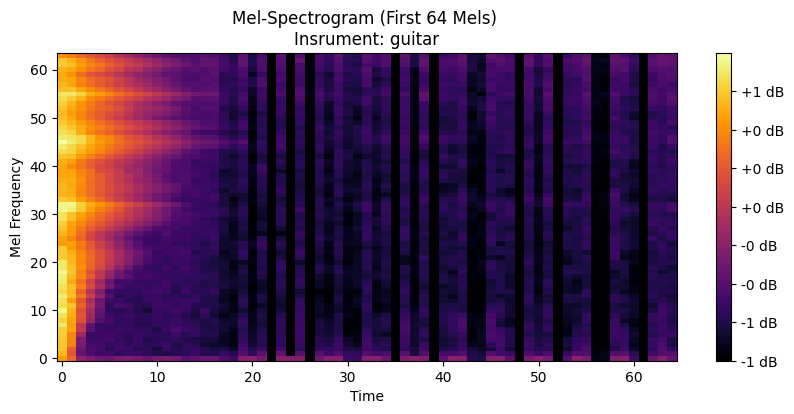

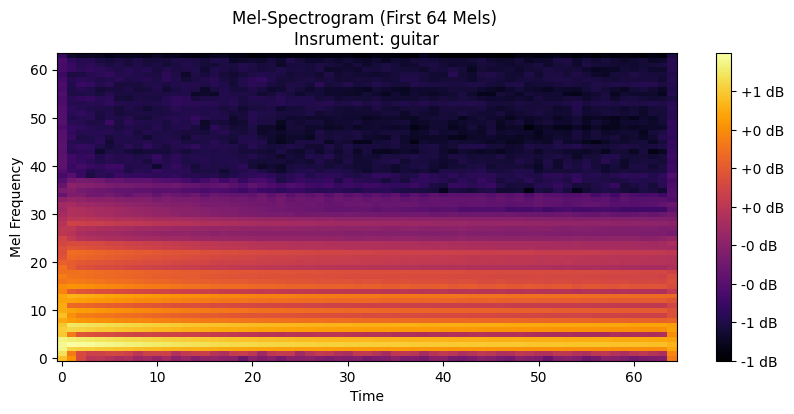

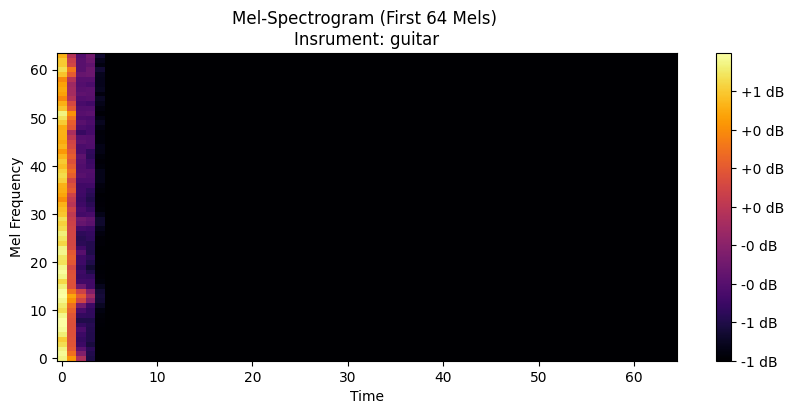

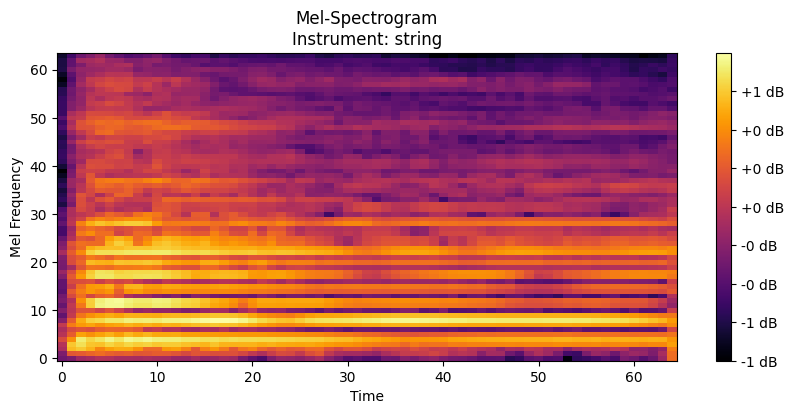

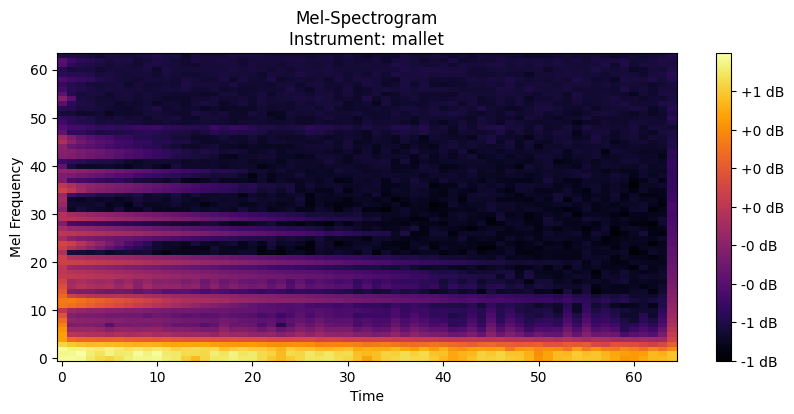

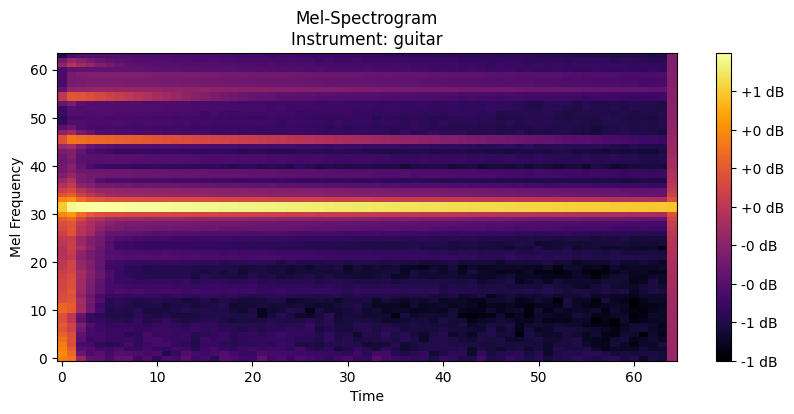

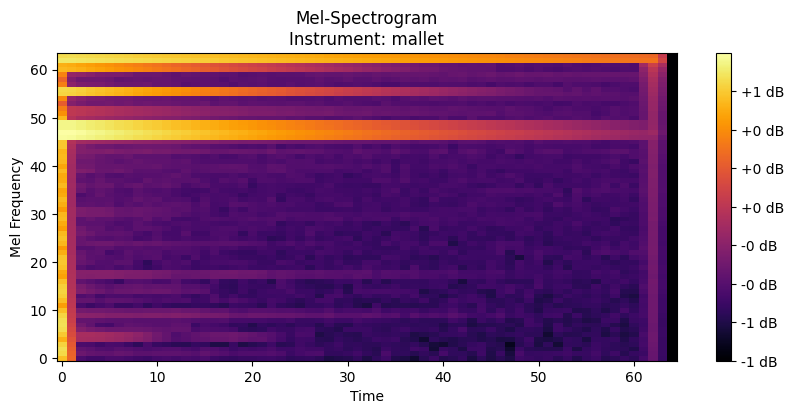

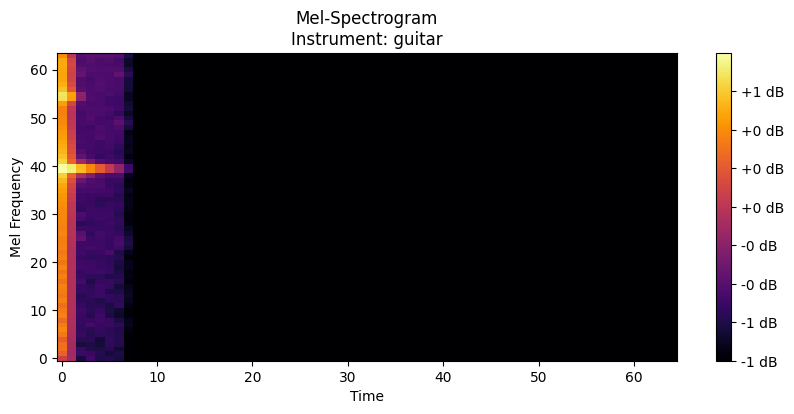

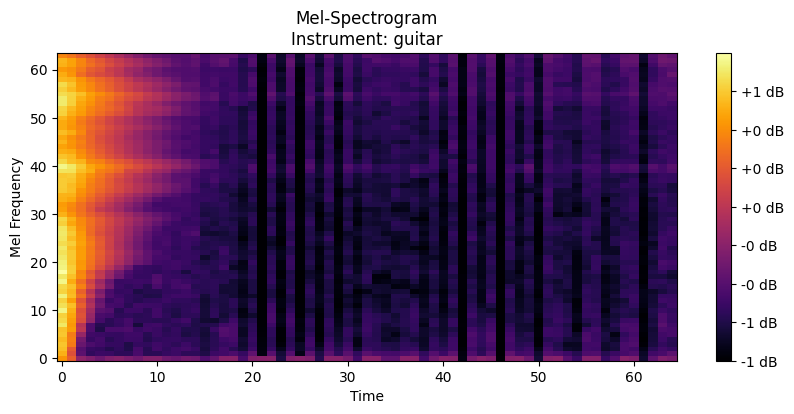

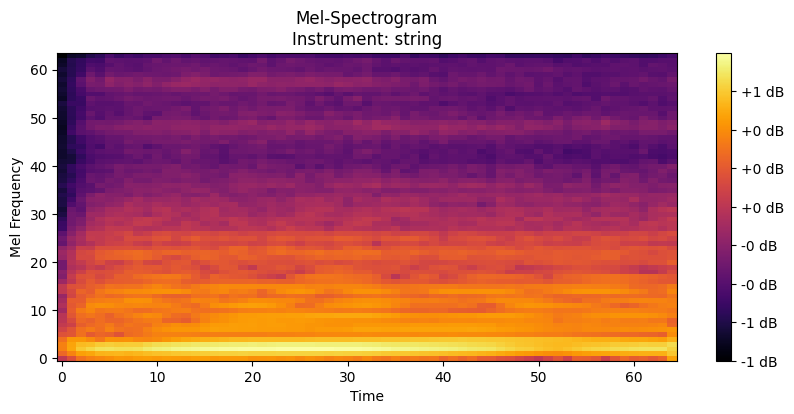

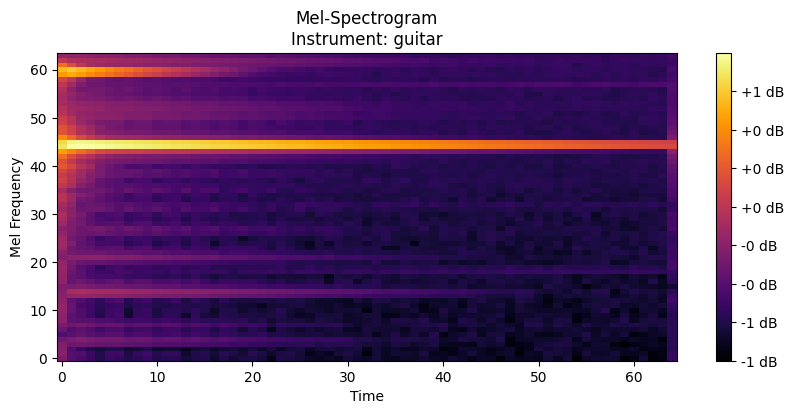

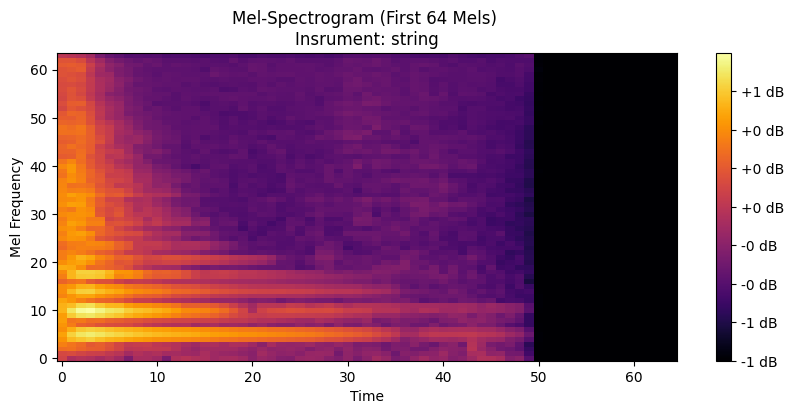

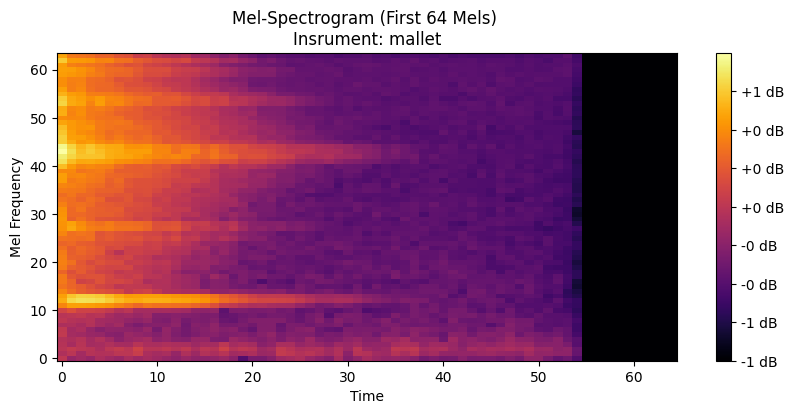

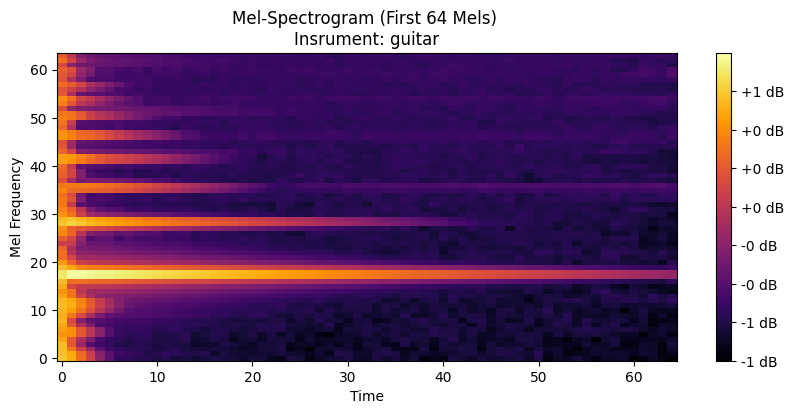

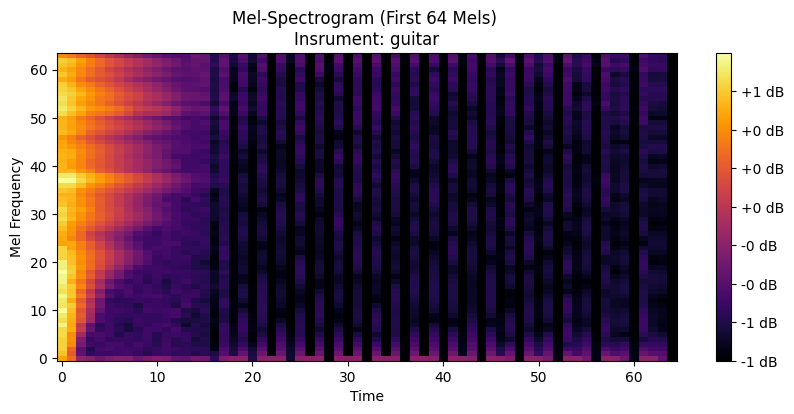

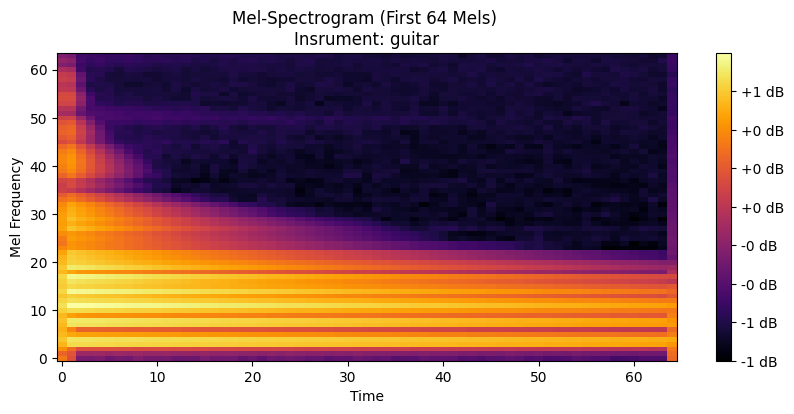

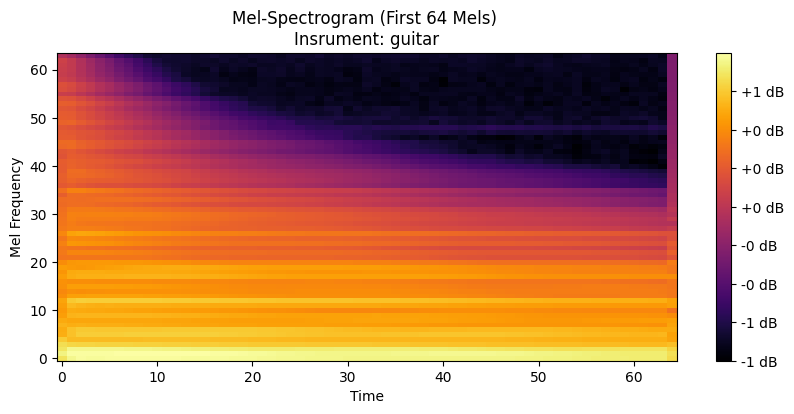

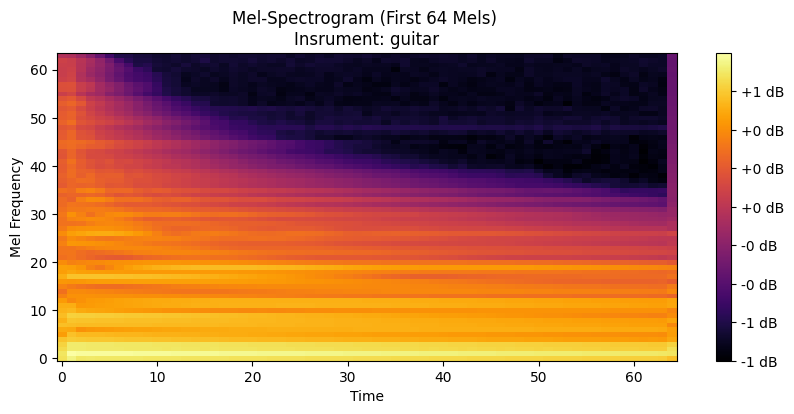

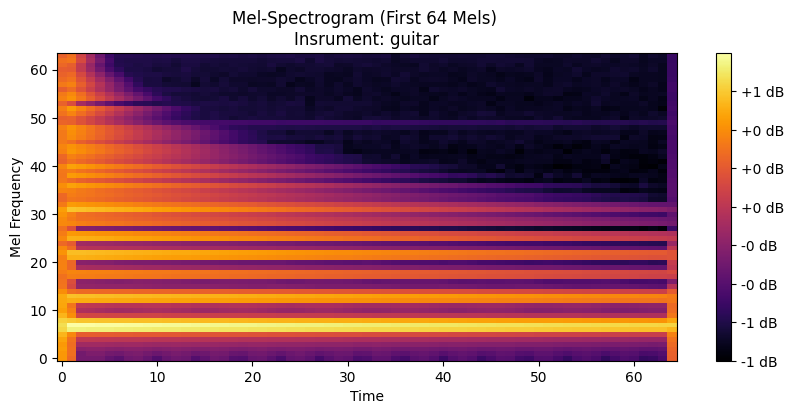

In [8]:
from matplotlib import image
# 4. Plot
import matplotlib.pyplot as plt

images, labels = next(iter(dataloader))

for i in range(len(images)):
  image = images[i].squeeze(0) # Squeeze the image to remove the channel dimension
  label = labels[i].item()
  int_to_name = {v: k for k, v in dataset.label_map.items()}
  name = int_to_name.get(label, "Unknown")


  plt.figure(figsize=(10, 4))
  plt.imshow(image.numpy(), origin='lower', aspect='auto', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f"Mel-Spectrogram (First 64 Mels) \nInsrument: {name}")
  plt.xlabel('Time')
  plt.ylabel('Mel Frequency')
  plt.show()

# Spectogram Decode + Encoder Test

Griffin-Lim Vocoder

BigVGAN Vocoder

In [ ]:
# --- DEBUG CELL: TEST BIGVGAN RECONSTRUCTION ---
import torch
import torchaudio
import torchaudio.transforms as T
import IPython.display as ipd
import matplotlib.pyplot as plt

# Import your V2 classes
from src.dataset import BigVGAN_NSynthDataset
from src.vocoder import BigVGAN_Vocoder

# 1. Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🚀 Running on: {device}")

# Initialize Dataset (V2)
dataset = BigVGAN_NSynthDataset(
    data_path='/content/nsynth_data/nsynth-valid',
    T_target=320,
    selected_families=['mallet']
)

# Initialize Vocoder
vocoder = dataset.vocoder

# 2. Get a real sample
idx = 10
mel_spec_image, label = dataset[idx]
original_file_path = dataset.files[idx]

print(f"🎵 Testing file")

# 3. Load Original Audio (Ground Truth)
orig_waveform, orig_sr = torchaudio.load(original_file_path)

# IMPORTANT: Resample original to 22050Hz for fair comparison
# (Since BigVGAN outputs 22050Hz)
if orig_sr != 22050:
    resampler = T.Resample(orig_sr, 22050)
    orig_waveform = resampler(orig_waveform)
    orig_sr = 22050

# 4. Reconstruct from the Spectrogram
# Input: [1, 80, 256] -> Output: [1, Time]
vocoder_input = mel_spec_image.unsqueeze(0) # Add batch dim
recon_waveform = vocoder.decode(vocoder_input).cpu()

# 5. LISTEN & COMPARE
print(f"\n--- 🎧 ORIGINAL AUDIO ({orig_sr} Hz) ---")
ipd.display(ipd.Audio(orig_waveform.squeeze().numpy(), rate=orig_sr))

print(f"\n--- 🤖 RECONSTRUCTED AUDIO (BigVGAN 22kHz) ---")
# FIX: Add .squeeze() to remove batch/channel dims [1, 1, T] -> [T]
ipd.display(ipd.Audio(recon_waveform.squeeze().numpy(), rate=22050))

# 6. Visual Comparison
plt.figure(figsize=(10, 4))

# Plot Spectrogram (Input to model)
plt.subplot(1, 2, 1)
plt.title("Input Mel Spectrogram (80 bands)")
# Squeeze to [80, 256] for plotting
plt.imshow(mel_spec_image.squeeze(), origin='lower', cmap='inferno', aspect='auto')

# Plot Waveform (Output of model)
plt.subplot(1, 2, 2)
plt.title("Reconstructed Waveform")
plt.plot(recon_waveform.flatten().numpy(), alpha=0.8)
plt.ylim(-1, 1)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🚀 Running on: cpu
BigVGAN NSynth Dataset: 663 files
⏳ Loading BigVGAN (Universal 22kHz)...
Loading weights from nvidia/bigvgan_v2_22khz_80band_fmax8k_256x
Removing weight norm...
✅ BigVGAN Loaded.
🎵 Testing file

--- 🎧 ORIGINAL AUDIO (22050 Hz) ---



--- 🤖 RECONSTRUCTED AUDIO (BigVGAN 22kHz) ---
